In [22]:
import gym
#import random
import numpy as np
import matplotlib.pyplot as plt

#import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

#from tflearn.layers.core import input_data, dropout, fully_connected
#from tflearn.layers.estimator import regression
from statistics import median, mean
from collections import Counter

env = gym.make("CartPole-v0")
env.reset()
goal_steps = 500
score_requirement = 60
initial_games = 50000

# Execute Episodes - Generate Examples

In [23]:
def executeEpisode(model = None):
    ''' Generate and example episode of [4 x observation(t), action(t), E[return(t)]]. 
        All values are in a (n x 6) numpy array where n is the number of steps for the 
        episode to finish or the limit of 200 steps'''
    score = 0
    example = np.zeros((goal_steps, 6) )
    prev_observation = env.reset() # list of 4 elements

    # --------- ITERATE UP TO 500 STEPS PER EPISODE -------------
    for t in range(goal_steps):

        # --------- GENERATE ACTION ------------
        # We can generate random actions or actions from the previous policy (i.e. prev nnet)
        if model == None or t == 0:
            action = env.action_space.sample()   # choose random action (0-left or 1-right)
        else:
            x = torch.tensor(   prev_observation,   dtype = torch.float    )
            action_prob, e_score = model.forward(x)
            action = np.argmax(   action_prob.detach().numpy()   )                

        observation, reward, done, info = env.step(action)

        # --------- STORE STATE-ACTION PAIR + SCORE ------------
        example[t, 0:4] = prev_observation[0:4]
        example[t, 4:6] = [action, score]

        prev_observation = np.array(observation)
        score += reward    # +1 for every frame we haven't fallen
        
        if done: 
            break
    
    example[:, 5] = score - example[:, 5]    # Convert scores to E[return] 
    return example[0:int(score), :] # we only want to return the parts with actual values

In [24]:
def GenerateExamples(model = None):
    # [OBS, MOVES, SCORE]
    allExamples = []
    accepted_scores = []    # just the scores that met our threshold
    
    # --------------- ITERATE THROUGH 10000 EPISODE ------------------
    for _ in range(initial_games):
       
        exampleGame = executeEpisode()
        
        # --------- SAVE EXAMPLE (EPISODE) IF (SCORE > THRESHOLD) ----------
        # Note, it does not save the score! Therefore all episodes with score > threshold
        # are treated equally (not the best way of doing this!)
        if exampleGame[0, 5] >= score_requirement:
            
            accepted_scores = np.append(accepted_scores, exampleGame[0, 5])
            if len(allExamples) == 0:
                allExamples = exampleGame
            else:
                allExamples = np.vstack(   (allExamples, exampleGame)   )
    
                
    # -------- SAVE TRAINING DATA -------------
    #training_data_save = np.array(examples)
    #np.save('saved.npy',training_data_save)
    
    # -------- PRINT STATS ------------
    avg_mean, avg_median = np.mean(accepted_scores), np.median(accepted_scores)
    print('Average accepted score:', avg_mean)
    print('Median score for accepted scores:', avg_median)
    print(Counter(accepted_scores))
    print(len(accepted_scores))
    
    return allExamples, avg_mean, avg_median


In [25]:
#eg, mean, med = GenerateExamples()

# Create Model

In [26]:
# Training settings
batch_size = 64

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.l1 = nn.Linear(4, 128)
        self.l2 = nn.Linear(128, 256)
        self.l3 = nn.Linear(256, 128)
        self.l4 = nn.Linear(128, 32)
        
        self.dp = nn.Dropout(p = 0.3)  # Suragnair used 0.3
        self.fc1 = nn.Linear(32, 2)    # want an action vector output: [log(prob right), log(prob left)]
        self.fc2 = nn.Linear(32, 1)    # Output the expected return

    def forward(self, obs):
        #in_size = x.size(0)
        x = F.relu(self.dp(self.l1(obs)))
        x = F.relu(self.dp(self.l2(x)))
        x = F.relu(self.dp(self.l3(x)))
        x = F.relu(self.dp(self.l4(x)))
        
        #x = x.view(in_size, -1)  # flatten the tensor
        a = self.fc1(self.dp(x))
        action_probs = F.log_softmax(a, dim = -1)    # choose the dimension such that we get something like 
                                          # [exp(-0.6723) +  exp(-0.7144)] = 1 for the output
        v = self.fc2(self.dp(x))  # get a linear value for the expected return
        return action_probs, v                      
    


model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Train Model

In [27]:
def train_model(epoch, examples):
    model.train()
    action_loss, value_loss, accuracy = [], [], []
    
    # ------------- CONVERT TO CORRECT DATA TYPE ----------------
    gpu = torch.device("cpu")
    allStates= torch.tensor(  examples[:, 0:4],  dtype = torch.float, device = gpu)       #reshapes into a (23002, 4) array
    allActions = torch.tensor(  examples[:, 4], dtype = torch.long, device = gpu)    #reshapes into a (23002, 2) array 
    allReturns = torch.tensor(  examples[:, 5],  dtype = torch.float, device = gpu) 
    
    # We should permute data before batching really. (X is a torch Variable)
    #permutation = torch.randperm(X.size()[0])

    
    for index in range(0, allStates.size()[0], batch_size):        

        # -------- GET BATCHES -----------
        #indices = permutation[i:i+batch_size]
        batch_idx = int(index / batch_size) + 1 #add one so stats print properly
        batch_states = allStates[index : index+batch_size] # torch.Size([64, 4])
        batch_actions = allActions[index : index+batch_size] # torch.Size([64])
        batch_returns = allReturns[index: index+batch_size] # torch.Size([64])

        # --------- TRAIN & BACKPROP ----------
        optimizer.zero_grad()
        pred_actions, state_value = model(batch_states) # torch.Size([64, 2]) and torch.Size([64, 1])
        
        a_loss = F.nll_loss(pred_actions, batch_actions)
        #print(pred_actions.detach(), batch_actions.detach(), a_loss.detach())
        # Suragnair uses tanh for state_values, but their values are E[win] = [-1, 1] where -1 = loss
        # Here we are using the length of time that we have been "up"
        v_loss = F.binary_cross_entropy(torch.sigmoid(state_value[:, 0]), torch.sigmoid(batch_returns))
        
        action_loss.append(a_loss)
        value_loss.append(v_loss)
        tot_loss = a_loss*100 + v_loss # pareto optimality?
        
        # Should try and get this to work with one hot!
        tot_loss.backward()
        optimizer.step()
                
        # --------- PRINT STATS --------------
        # Get array of predicted actions and compare with target actions to compute accuracy
        arg = torch.argmax(pred_actions, dim = 1)
        accuracy.append(  1 - (torch.abs(arg - batch_actions).sum().detach().numpy()) / batch_size    ) #counts the different ones
        
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} \tAccuracy: {:.5f}'.format(
                epoch, 
                batch_idx * batch_size, 
                allStates.size()[0],
                100 * batch_idx * batch_size / allStates.size()[0], 
                tot_loss,
                accuracy[batch_idx - 1])
                  
             )

    return action_loss, value_loss, accuracy

In [28]:
training_data, avg_mean, avg_median = GenerateExamples()

Average accepted score: 71.95416164053076
Median score for accepted scores: 68.0
Counter({61.0: 62, 62.0: 60, 60.0: 59, 64.0: 54, 63.0: 51, 68.0: 46, 65.0: 37, 67.0: 37, 70.0: 29, 71.0: 29, 66.0: 27, 69.0: 26, 74.0: 22, 73.0: 20, 72.0: 19, 78.0: 18, 75.0: 18, 82.0: 17, 79.0: 17, 76.0: 17, 77.0: 14, 88.0: 12, 81.0: 11, 83.0: 10, 86.0: 9, 93.0: 9, 87.0: 8, 111.0: 7, 80.0: 7, 84.0: 7, 91.0: 7, 94.0: 7, 92.0: 6, 85.0: 6, 90.0: 4, 103.0: 4, 95.0: 4, 98.0: 4, 101.0: 3, 89.0: 3, 96.0: 2, 105.0: 2, 97.0: 2, 109.0: 2, 123.0: 1, 122.0: 1, 161.0: 1, 107.0: 1, 106.0: 1, 108.0: 1, 133.0: 1, 99.0: 1, 134.0: 1, 100.0: 1, 112.0: 1, 130.0: 1, 102.0: 1, 114.0: 1})
829


In [29]:
a_loss, v_loss, batch_acc = train_model(1, training_data)

Train Epoch: 1 [64/59650 (0%)]	Loss: 69.999763 	Accuracy: 0.50000
Train Epoch: 1 [128/59650 (0%)]	Loss: 70.459267 	Accuracy: 0.53125
Train Epoch: 1 [192/59650 (0%)]	Loss: 70.176376 	Accuracy: 0.45312
Train Epoch: 1 [256/59650 (0%)]	Loss: 68.913795 	Accuracy: 0.51562
Train Epoch: 1 [320/59650 (1%)]	Loss: 70.595673 	Accuracy: 0.48438
Train Epoch: 1 [384/59650 (1%)]	Loss: 71.125923 	Accuracy: 0.53125
Train Epoch: 1 [448/59650 (1%)]	Loss: 69.825241 	Accuracy: 0.48438
Train Epoch: 1 [512/59650 (1%)]	Loss: 70.436287 	Accuracy: 0.54688
Train Epoch: 1 [576/59650 (1%)]	Loss: 69.572845 	Accuracy: 0.54688
Train Epoch: 1 [640/59650 (1%)]	Loss: 69.650200 	Accuracy: 0.50000
Train Epoch: 1 [704/59650 (1%)]	Loss: 68.372543 	Accuracy: 0.53125
Train Epoch: 1 [768/59650 (1%)]	Loss: 68.656807 	Accuracy: 0.53125
Train Epoch: 1 [832/59650 (1%)]	Loss: 68.359062 	Accuracy: 0.56250
Train Epoch: 1 [896/59650 (2%)]	Loss: 66.347359 	Accuracy: 0.59375
Train Epoch: 1 [960/59650 (2%)]	Loss: 67.448250 	Accuracy: 0.60

Train Epoch: 1 [10368/59650 (17%)]	Loss: 70.583183 	Accuracy: 0.59375
Train Epoch: 1 [10432/59650 (17%)]	Loss: 67.823082 	Accuracy: 0.59375
Train Epoch: 1 [10496/59650 (18%)]	Loss: 69.341728 	Accuracy: 0.54688
Train Epoch: 1 [10560/59650 (18%)]	Loss: 70.116112 	Accuracy: 0.56250
Train Epoch: 1 [10624/59650 (18%)]	Loss: 68.241959 	Accuracy: 0.51562
Train Epoch: 1 [10688/59650 (18%)]	Loss: 68.652016 	Accuracy: 0.60938
Train Epoch: 1 [10752/59650 (18%)]	Loss: 68.081116 	Accuracy: 0.57812
Train Epoch: 1 [10816/59650 (18%)]	Loss: 66.944519 	Accuracy: 0.57812
Train Epoch: 1 [10880/59650 (18%)]	Loss: 67.539726 	Accuracy: 0.56250
Train Epoch: 1 [10944/59650 (18%)]	Loss: 66.908852 	Accuracy: 0.62500
Train Epoch: 1 [11008/59650 (18%)]	Loss: 69.722771 	Accuracy: 0.54688
Train Epoch: 1 [11072/59650 (19%)]	Loss: 66.600601 	Accuracy: 0.67188
Train Epoch: 1 [11136/59650 (19%)]	Loss: 68.108994 	Accuracy: 0.59375
Train Epoch: 1 [11200/59650 (19%)]	Loss: 69.338120 	Accuracy: 0.57812
Train Epoch: 1 [1126

Train Epoch: 1 [20416/59650 (34%)]	Loss: 66.129822 	Accuracy: 0.67188
Train Epoch: 1 [20480/59650 (34%)]	Loss: 69.200584 	Accuracy: 0.57812
Train Epoch: 1 [20544/59650 (34%)]	Loss: 68.319145 	Accuracy: 0.53125
Train Epoch: 1 [20608/59650 (35%)]	Loss: 67.124542 	Accuracy: 0.56250
Train Epoch: 1 [20672/59650 (35%)]	Loss: 63.909225 	Accuracy: 0.59375
Train Epoch: 1 [20736/59650 (35%)]	Loss: 64.396286 	Accuracy: 0.62500
Train Epoch: 1 [20800/59650 (35%)]	Loss: 67.588280 	Accuracy: 0.57812
Train Epoch: 1 [20864/59650 (35%)]	Loss: 67.793663 	Accuracy: 0.64062
Train Epoch: 1 [20928/59650 (35%)]	Loss: 65.052231 	Accuracy: 0.67188
Train Epoch: 1 [20992/59650 (35%)]	Loss: 67.322266 	Accuracy: 0.59375
Train Epoch: 1 [21056/59650 (35%)]	Loss: 71.079689 	Accuracy: 0.50000
Train Epoch: 1 [21120/59650 (35%)]	Loss: 67.256966 	Accuracy: 0.62500
Train Epoch: 1 [21184/59650 (36%)]	Loss: 65.469040 	Accuracy: 0.59375
Train Epoch: 1 [21248/59650 (36%)]	Loss: 68.069168 	Accuracy: 0.51562
Train Epoch: 1 [2131

Train Epoch: 1 [30912/59650 (52%)]	Loss: 71.449623 	Accuracy: 0.53125
Train Epoch: 1 [30976/59650 (52%)]	Loss: 64.948540 	Accuracy: 0.65625
Train Epoch: 1 [31040/59650 (52%)]	Loss: 67.809067 	Accuracy: 0.59375
Train Epoch: 1 [31104/59650 (52%)]	Loss: 65.894279 	Accuracy: 0.67188
Train Epoch: 1 [31168/59650 (52%)]	Loss: 67.998680 	Accuracy: 0.51562
Train Epoch: 1 [31232/59650 (52%)]	Loss: 67.642296 	Accuracy: 0.62500
Train Epoch: 1 [31296/59650 (52%)]	Loss: 66.102722 	Accuracy: 0.62500
Train Epoch: 1 [31360/59650 (53%)]	Loss: 67.087997 	Accuracy: 0.64062
Train Epoch: 1 [31424/59650 (53%)]	Loss: 65.209198 	Accuracy: 0.60938
Train Epoch: 1 [31488/59650 (53%)]	Loss: 65.446312 	Accuracy: 0.56250
Train Epoch: 1 [31552/59650 (53%)]	Loss: 66.817657 	Accuracy: 0.64062
Train Epoch: 1 [31616/59650 (53%)]	Loss: 68.038887 	Accuracy: 0.65625
Train Epoch: 1 [31680/59650 (53%)]	Loss: 69.052170 	Accuracy: 0.57812
Train Epoch: 1 [31744/59650 (53%)]	Loss: 64.680847 	Accuracy: 0.60938
Train Epoch: 1 [3180

Train Epoch: 1 [41216/59650 (69%)]	Loss: 66.588722 	Accuracy: 0.64062
Train Epoch: 1 [41280/59650 (69%)]	Loss: 64.815247 	Accuracy: 0.64062
Train Epoch: 1 [41344/59650 (69%)]	Loss: 64.575150 	Accuracy: 0.64062
Train Epoch: 1 [41408/59650 (69%)]	Loss: 75.876587 	Accuracy: 0.51562
Train Epoch: 1 [41472/59650 (70%)]	Loss: 65.701202 	Accuracy: 0.64062
Train Epoch: 1 [41536/59650 (70%)]	Loss: 63.653172 	Accuracy: 0.67188
Train Epoch: 1 [41600/59650 (70%)]	Loss: 65.498665 	Accuracy: 0.67188
Train Epoch: 1 [41664/59650 (70%)]	Loss: 69.231377 	Accuracy: 0.59375
Train Epoch: 1 [41728/59650 (70%)]	Loss: 73.048233 	Accuracy: 0.60938
Train Epoch: 1 [41792/59650 (70%)]	Loss: 67.713074 	Accuracy: 0.56250
Train Epoch: 1 [41856/59650 (70%)]	Loss: 70.104187 	Accuracy: 0.59375
Train Epoch: 1 [41920/59650 (70%)]	Loss: 67.471748 	Accuracy: 0.57812
Train Epoch: 1 [41984/59650 (70%)]	Loss: 68.149437 	Accuracy: 0.64062
Train Epoch: 1 [42048/59650 (70%)]	Loss: 65.939865 	Accuracy: 0.59375
Train Epoch: 1 [4211

Train Epoch: 1 [49216/59650 (83%)]	Loss: 63.870842 	Accuracy: 0.62500
Train Epoch: 1 [49280/59650 (83%)]	Loss: 67.050957 	Accuracy: 0.60938
Train Epoch: 1 [49344/59650 (83%)]	Loss: 71.050583 	Accuracy: 0.59375
Train Epoch: 1 [49408/59650 (83%)]	Loss: 66.676697 	Accuracy: 0.59375
Train Epoch: 1 [49472/59650 (83%)]	Loss: 66.211464 	Accuracy: 0.68750
Train Epoch: 1 [49536/59650 (83%)]	Loss: 67.055504 	Accuracy: 0.56250
Train Epoch: 1 [49600/59650 (83%)]	Loss: 66.866776 	Accuracy: 0.62500
Train Epoch: 1 [49664/59650 (83%)]	Loss: 63.453583 	Accuracy: 0.64062
Train Epoch: 1 [49728/59650 (83%)]	Loss: 63.870789 	Accuracy: 0.67188
Train Epoch: 1 [49792/59650 (83%)]	Loss: 67.447380 	Accuracy: 0.60938
Train Epoch: 1 [49856/59650 (84%)]	Loss: 66.110802 	Accuracy: 0.67188
Train Epoch: 1 [49920/59650 (84%)]	Loss: 64.649818 	Accuracy: 0.56250
Train Epoch: 1 [49984/59650 (84%)]	Loss: 68.501762 	Accuracy: 0.53125
Train Epoch: 1 [50048/59650 (84%)]	Loss: 65.725800 	Accuracy: 0.59375
Train Epoch: 1 [5011

Train Epoch: 1 [56896/59650 (95%)]	Loss: 65.884361 	Accuracy: 0.59375
Train Epoch: 1 [56960/59650 (95%)]	Loss: 63.997719 	Accuracy: 0.60938
Train Epoch: 1 [57024/59650 (96%)]	Loss: 65.747795 	Accuracy: 0.62500
Train Epoch: 1 [57088/59650 (96%)]	Loss: 66.964928 	Accuracy: 0.54688
Train Epoch: 1 [57152/59650 (96%)]	Loss: 66.127731 	Accuracy: 0.60938
Train Epoch: 1 [57216/59650 (96%)]	Loss: 68.047005 	Accuracy: 0.62500
Train Epoch: 1 [57280/59650 (96%)]	Loss: 68.190361 	Accuracy: 0.57812
Train Epoch: 1 [57344/59650 (96%)]	Loss: 65.419518 	Accuracy: 0.64062
Train Epoch: 1 [57408/59650 (96%)]	Loss: 62.701382 	Accuracy: 0.68750
Train Epoch: 1 [57472/59650 (96%)]	Loss: 64.948868 	Accuracy: 0.60938
Train Epoch: 1 [57536/59650 (96%)]	Loss: 65.243637 	Accuracy: 0.65625
Train Epoch: 1 [57600/59650 (97%)]	Loss: 64.377571 	Accuracy: 0.57812
Train Epoch: 1 [57664/59650 (97%)]	Loss: 65.484154 	Accuracy: 0.59375
Train Epoch: 1 [57728/59650 (97%)]	Loss: 74.163582 	Accuracy: 0.59375
Train Epoch: 1 [5779

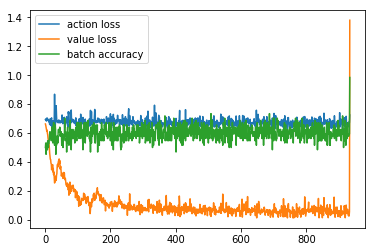

In [30]:
x = np.linspace(1, len(a_loss), num = len(a_loss))
plt.plot(x, a_loss)
plt.plot(x, v_loss)
plt.plot(x, batch_acc)
plt.legend(["action loss", "value loss", "batch accuracy"])
plt.show()

# Test the Model 

In [31]:
def test():
    
    model.eval()
    scores, expected_scores, choices = [], np.zeros(goal_steps), []
    
    # ------- PLAY SOME TEST GAMES ----------
    for each_game in range(50):
        env.reset()
        score, E_score = 0, []
        game_memory, prev_obs = [], []
        
        for _ in range(goal_steps):    # play up to (500) frames
            #env.render()
            
            # ----- GENERATE AN ACTION -------
            if len(prev_obs)==0:    # start by taking a random action
                action = env.action_space.sample()   
                
            else:                   # After that take the best predicted action by the neural net
                x = torch.tensor(   prev_obs,   dtype = torch.float    )
                action_prob, e_score = model.forward(x)
                action = np.argmax(   action_prob.detach().numpy()   )
                E_score.append(   np.array(e_score.detach())[0]   )  # see how the game updates it expected score as we move through

            new_observation, reward, done, info = env.step(action)
            prev_obs = new_observation
            
            # ----- RECORD RESULTS -------
            choices.append(action)   # just so we can work out the ratio of what we're predicting
            
            game_memory.append([new_observation, action])
            score += reward
            if done: break

        scores.append(score)    # Record the score of each game
        padding = np.zeros(int(goal_steps - score + 1), dtype = int)
        E_score = np.append([np.array(E_score)], [padding])
        expected_scores = np.vstack((expected_scores, E_score))

    print("Score Req: ", score_requirement)
    print('Average Score:',sum(scores)/len(scores))
    print('choice 1 (right): {:.4f}  choice 0 (left): {:.4f}'.format(choices.count(1)/len(choices),choices.count(0)/len(choices)))
    print(Counter(scores))
    
    return expected_scores

Score Req:  60
Average Score: 147.0
choice 1 (right): 0.4835  choice 0 (left): 0.5165
Counter({153.0: 3, 145.0: 3, 129.0: 2, 133.0: 2, 135.0: 2, 137.0: 2, 157.0: 2, 127.0: 2, 121.0: 1, 159.0: 1, 173.0: 1, 161.0: 1, 168.0: 1, 119.0: 1, 179.0: 1, 136.0: 1, 169.0: 1, 110.0: 1, 163.0: 1, 131.0: 1, 152.0: 1, 160.0: 1, 107.0: 1, 111.0: 1, 167.0: 1, 134.0: 1, 132.0: 1, 174.0: 1, 183.0: 1, 149.0: 1, 150.0: 1, 176.0: 1, 171.0: 1, 147.0: 1, 148.0: 1, 140.0: 1, 115.0: 1, 178.0: 1, 155.0: 1, 182.0: 1})


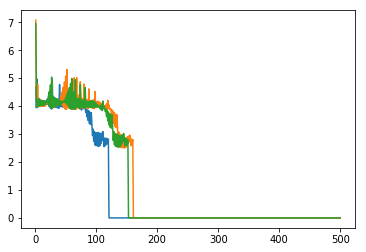

In [32]:
expected_scores = test()
x = np.linspace(1, len(expected_scores[0]), num = len(expected_scores[0]))
plt.plot(x, expected_scores[1])
plt.plot(x, expected_scores[6])
plt.plot(x, expected_scores[3])
plt.show()
